# Import libraries

In [129]:
import numpy as np # calculations with arrays
import pandas as pd # user-friendly DataFrames for data representation
import sklearn # machine learning algorithms
from sklearn import ensemble, linear_model
from sklearn.metrics import log_loss
from sklearn import cross_validation
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
import xgboost as xgb
import matplotlib.pyplot as plt # import plot functions
# necessary to plot in jupyter notebook:
%matplotlib inline
import seaborn as sns # make plots beautiful

# Load data

In [2]:
train = pd.read_csv('train2.csv')
test = pd.read_csv('test2.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Data

In [3]:
train.head(3)

year  day  team1  team2  score1  score2 target
0  2998   19    317    131     336     278   True
1  2998   28     61     29     301     259   True
2  2998   28    110    141     359     267   True

In [4]:
train.shape

(101609, 7)

In [5]:
test.head(3)

Id  year  team1  team2
0   0  3021    363    161
1   1  3021    286      2
2   2  3020    232     52

In [6]:
sample_submission.head(3)

Id  target
0   0     0.5
1   1     0.5
2   2     0.5

In [7]:
print 'train.shape = ', train.shape
print 'test.shape = ', test.shape
print 'sample_submission.shape = ', sample_submission.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-7-4fd11fc4112d>, line 1)

# Work with categorical features

# Make dataset for cross-vallidation using One-Hot-Encoding

In [8]:
enc = OneHotEncoder(sparse=False)

In [9]:
train_team1 = pd.DataFrame(enc.fit_transform(train[['team1']]))

In [10]:
print 'train_team1.shape = ', train_team1.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-10-420bd4dd2b48>, line 1)

In [11]:
train_team2 = pd.DataFrame(enc.transform(train[['team2']]))

In [12]:
print 'train_team2.shape = ', train_team2.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-12-220f88f414c6>, line 1)

In [13]:
train_teams = pd.concat([train_team1, train_team2], axis=1)

In [14]:
print 'train_team1 + train_team2 = ', train_teams.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-14-86ee706d0bfd>, line 1)

In [ ]:
test_team1 = pd.DataFrame(enc.transform(test[['team1']]))

In [ ]:
print 'test_team1 = ', test_team1.shape

In [15]:
test_team2 = pd.DataFrame(enc.transform(test[['team2']]))

In [16]:
print 'test_team2 = ', test_team2.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-16-0f3922acb5e1>, line 1)

In [17]:
test_teams = pd.concat([test_team1, test_team2], axis=1)

NameError: name 'test_team1' is not defined

In [18]:
print 'test_teams.shape = ', test_teams.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-18-23466d088f6b>, line 1)

# Feature engenering

### Добавили среднее число очков: для команды team1 – среднее количество очков, набранных дома; для команды team2 – среднее количество очков, набранных в гостях

In [21]:
df_train = train
df_test = test

In [22]:
means_score = {}
for index_team in list(df_train.team1.unique()):
    df_for_team1 = df_train[df_train['team1'] == index_team]
    df_for_team2 = df_train[df_train['team2'] == index_team]
    means_score[index_team] = [int(df_for_team1.score1.mean()), int(df_for_team2.score2.mean())]
#print(means_score)
#for c in means_score:
#    print(means_score[c])

In [23]:
teams_not_train = []
for index_team in list(df_test.team1.unique()):
    if index_team not in list(df_train.team1.unique()):
        teams_not_train.append(index_team)
for index_team in list(df_test.team2.unique()):
    if index_team not in list(df_train.team1.unique()):
        teams_not_train.append(index_team)

In [24]:
for index_team in teams_not_train:
    means_score[index_team] = [df_train.score1.mean(), df_train.score2.mean()]

In [25]:
features_to_concat_train = []
for year, day, team1, team2, _, __, ___ in df_train.values:
    features_to_concat_train.append([means_score[team1][0], means_score[team2][1]])
features_to_concat_test = []
for Id, year, team1, team2 in df_test.values:
    features_to_concat_test.append([means_score[team1][0], means_score[team2][1]])

In [26]:
df_feature_to_concat_train = pd.DataFrame(data=features_to_concat_train, columns=['mean_home_score', 'mean_away_score'])

In [27]:
df_feature_to_concat_test = pd.DataFrame(data=features_to_concat_test, columns=['mean_home_score', 'mean_away_score'])

### Добавляем процент побед: для team1 – процент побед дома; для team2 – процент побед в гостях

In [28]:
percentage_wins = {}
for index_team in list(df_train.team1.unique()):
    df_for_team_home = df_train[df_train['team1'] == index_team]
    df_for_team_away = df_train[df_train['team2'] == index_team]
    percentage_wins[index_team] = [df_for_team_home.target.mean(), 1 - df_for_team_away.target.mean()]

In [29]:
for index_team in teams_not_train:
    percentage_wins[index_team] = [df_train.target.mean(), 1 - df_train.target.mean()]

In [30]:
percentage_of_wins_train = []
for year, day, team1, team2, _, __, ___ in df_train.values:
    percentage_of_wins_train.append([percentage_wins[team1][0], percentage_wins[team2][1]])
percentage_of_wins_test = []
for Id, year, team1, team2 in df_test.values:
    percentage_of_wins_test.append([percentage_wins[team1][0], percentage_wins[team2][1]])

In [31]:
df_percentage_of_wins_train = pd.DataFrame(data=percentage_of_wins_train, columns=['percentage_wins_home', 'percentage_wins_away'])

In [32]:
df_percentage_of_wins_test = pd.DataFrame(data=percentage_of_wins_test, columns=['percentage_wins_home', 'percentage_wins_away'])

   # Make X_train, X_test, y_train, y_test

### Делаем X_train

In [33]:
X_train_all_feat = pd.concat([train, df_feature_to_concat_train, df_percentage_of_wins_train], axis=1)

In [34]:
print 'X_train_all_feat.shape = ', X_train_all_feat.shape

X_train_all_feat.shape =  (101609, 11)


In [34]:
X_train_all_feat.head(2)

year  day  team1  team2  score1  score2 target  mean_home_score  \
0  2998   19    317    131     336     278   True              289   
1  2998   28     61     29     301     259   True              273   

   mean_away_score  percentage_wins_home  percentage_wins_away  
0              285              0.688073              0.640118  
1              276              0.503333              0.556962

In [35]:
y_train =  X_train_all_feat[['target']]

In [36]:
X_train_not_scaled = X_train_all_feat.drop(['day', 'team1', 'team2','score1', 'score2', 'target'], axis=1)

In [37]:
X_train_not_scaled.head(2)

year  mean_home_score  mean_away_score  percentage_wins_home  \
0  2998              289              285              0.688073   
1  2998              273              276              0.503333   

   percentage_wins_away  
0              0.640118  
1              0.556962

In [38]:
X_train_years = X_train_not_scaled.drop(['mean_home_score','mean_away_score','percentage_wins_home','percentage_wins_home','percentage_wins_away'], axis = 1)

In [39]:
X_train_years.head(2)

year
0  2998
1  2998

In [40]:
print 'y_train.shape = ', y_train.shape

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-40-fdab9f5dd08e>, line 1)

In [41]:
X_test_all_feat = pd.concat([test, df_feature_to_concat_test, df_percentage_of_wins_test], axis=1)

In [42]:
X_test_all_feat.shape

(125207, 8)

In [43]:
X_test_all_feat.head(2)

Id  year  team1  team2  mean_home_score  mean_away_score  \
0   0  3021    363    161            250.0            278.0   
1   1  3021    286      2            271.0            242.0   

   percentage_wins_home  percentage_wins_away  
0              0.428571              0.535826  
1              0.593567              0.394464

In [44]:
X_test_not_scaled = X_test_all_feat.drop(['Id', 'team1', 'team2'], axis=1)

In [45]:
X_test_not_scaled.head(2)

year  mean_home_score  mean_away_score  percentage_wins_home  \
0  3021            250.0            278.0              0.428571   
1  3021            271.0            242.0              0.593567   

   percentage_wins_away  
0              0.535826  
1              0.394464

In [46]:
X_train = pd.concat([X_train_years, train_teams], axis=1)

In [65]:
print 'X_train.shape = ', X_train.shape

X_train.shape =  (101609, 707)


In [47]:
X_train.head(2)

year    0    1    2    3    4    5    6    7    8 ...   343  344  345  346  \
0  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 707 columns]

In [48]:
test.head(2)

Id  year  team1  team2
0   0  3021    363    161
1   1  3021    286      2

In [49]:
X_test_without_teams = test.drop(['team1','team2','Id'], axis=1)

In [50]:
X_test = pd.concat([X_test_without_teams, test_teams], axis=1)

NameError: name 'test_teams' is not defined

In [70]:
print 'X_test.shape = ', X_test.shape

X_test.shape =  (125207, 707)


In [51]:
X_test_year.head(3)

NameError: name 'X_test_year' is not defined

In [52]:
X_test.shape

NameError: name 'X_test' is not defined

In [53]:
X_train.head(3)

year    0    1    2    3    4    5    6    7    8 ...   343  344  345  346  \
0  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 707 columns]

In [75]:
X_train.shape

(101609, 707)

# X_train, X_test !

In [114]:
X_train.year.unique()

array([2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008,
       3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019])

In [115]:
## Дропаем год!
X_train_not_year = X_train.drop('year', axis=1)

In [113]:
80527. / X_train.shape[0]

0.7925183792774262

In [116]:
train_data = pd.DataFrame(X_train_not_year.values[:80527, :])

In [117]:
test_data = pd.DataFrame(X_train_not_year.values[80527:, :])

In [59]:
train_data.shape

(75278, 706)

In [60]:
test_data.shape

(26331, 706)

In [120]:
train_labels = y_train[:80527]

In [121]:
test_labels = y_train[80527:]

In [61]:
train_team2_not_year = pd.DataFrame(train_team2.values[:75278, :])

In [62]:
train_team1_not_year = pd.DataFrame(train_team1.values[:75278, :])

In [63]:
test_team2_not_year = pd.DataFrame(train_team2.values[75278:, :])

In [64]:
test_team1_not_year = pd.DataFrame(train_team1.values[75278:, :])

In [65]:
test_team2_not_year.shape

(26331, 353)

In [66]:
df_to_add_teams_train = pd.concat([train_team2_not_year, train_team1_not_year], axis=1)

In [67]:
df_to_add_teams_train.shape

(75278, 706)

In [68]:
df_to_add_teams_train.columns = [i for i in range(706)]

In [69]:
df_to_add_teams_test.columns =[i for i in range(706)]

NameError: name 'df_to_add_teams_test' is not defined

In [70]:
df_to_add_teams_train.shape

(75278, 706)

In [71]:
df_to_add_teams_test = pd.concat([test_team2_not_year, test_team1_not_year], axis=1)

In [72]:
df_to_add_teams_test.shape

(26331, 706)

In [73]:
train_data.shape

(75278, 706)

In [74]:
train_data.head(2)

0    1    2    3    4    5    6    7    8    9   ...   696  697  698  699  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   700  701  702  703  704  705  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 706 columns]

In [75]:
df_to_add_teams_train.shape

(75278, 706)

In [76]:
df_to_add_teams_train.head(2)

0    1    2    3    4    5    6    7    8    9   ...   696  697  698  699  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   700  701  702  703  704  705  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 706 columns]

In [77]:
df_X_train = pd.concat([train_data, df_to_add_teams_train], axis=0)

In [78]:
df_X_train.shape

(150556, 706)

In [79]:
len(df_y_train)

NameError: name 'df_y_train' is not defined

In [80]:
test_data.head(2)

0    1    2    3    4    5    6    7    8    9   ...   696  697  698  699  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   700  701  702  703  704  705  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 706 columns]

In [81]:
df_to_add_teams_test.head(2)

0    1    2    3    4    5    6    7    8    9   ...   343  344  345  346  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 706 columns]

In [82]:
test_data.head(2)

0    1    2    3    4    5    6    7    8    9   ...   696  697  698  699  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   700  701  702  703  704  705  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 706 columns]

In [83]:
df_to_add_teams_test.head(2)

0    1    2    3    4    5    6    7    8    9   ...   343  344  345  346  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 706 columns]

In [88]:
df_to_add_teams_test.columns = [i for i in range(706)]

In [89]:
df_X_test = pd.concat([test_data, df_to_add_teams_test], axis=0)

In [90]:
df_X_test.shape

(52662, 706)

In [91]:
df_X_train.shape

(150556, 706)

In [92]:
y_to_add = list(map(lambda x: 1-x, y_train.values.T[0]))[:75278]

In [93]:
y_tr = y_train.values.T[0][:75278]

In [94]:
df_y_train = list(y_tr)+list(y_to_add)

In [95]:
len(df_y_train)

150556

In [96]:
y_to_add_test = list(map(lambda x: 1-x, y_train.values.T[0]))[75278:]

In [97]:
len(y_to_add_test)

26331

In [98]:
df_X_test.shape

(52662, 706)

In [99]:
y_te = y_train.values.T[0][75278:]

In [100]:
df_y_test = list(y_te)+list(y_to_add_test)

In [101]:
len(df_y_test)

52662

In [102]:
df_X_train.shape

(150556, 706)

In [103]:
len(df_y_train)

150556

In [104]:
df_X_test.shape

(52662, 706)

In [105]:
len(df_y_test)

52662

# df_X_train - расширенная train.csv, y_train_arr - ответы под df_X_train

In [106]:
param = {'C': np.linspace(0.2, 1.6, 10)}

In [107]:
lin_cl = linear_model.LogisticRegression(C=0.1)

In [108]:
lin_cl.fit(df_X_train.values, np.array(df_y_train.T)[0])

AttributeError: 'list' object has no attribute 'T'

In [109]:
log_loss(df_y_test, lin_cl.predict_proba(df_X_test)[:,1])

NotFittedError: Call fit before prediction

In [110]:
xgb = xgboost.XGBClassifier(n_estimators=150)

In [111]:
xgb.fit(df_X_train.values, np.array(df_y_train.T)[0])

AttributeError: 'list' object has no attribute 'T'

In [332]:
log_loss(df_y_test, xgb.predict_proba(df_X_test)[:,1])

0.67831329690948727

In [122]:
lin_cl = linear_model.LogisticRegression(C=0.8)

In [128]:
lin_cl.fit(train_data, train_labels.values.T[0])

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [130]:
xgb_cl = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=150)

In [131]:
xgb_cl.fit(train_data, train_labels.values.T[0])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [132]:
lin_reg_best = pd.read_csv('lin_reg.csv')

In [133]:
xgb_best = pd.read_csv('mighty_xgboost-2.csv')

In [136]:
lin_reg_best.drop('Id', axis=1, inplace=True)

In [137]:
xgb_best.drop('Id', axis=1, inplace=True)

In [141]:
lin_values = lin_reg_best.values.T[0]
xgb_values = xgb_best.values.T[0]

In [160]:
alpha = 0.75

In [161]:
y_pred = lin_values * alpha + xgb_values * (1 - alpha) 

# Вывод ответа

In [162]:
ss = sample_submission.copy()
ss.target = y_pred
ss.to_csv('ans.csv', index=False)

# Попытка n2

In [178]:
train.day.unique()

array([ 19,  28,  30,  31,  33,  35,  37,  38,  40,  42,  44,  46,  47,
        49,  51,  53,  54,  56,  58,  60,  61,  63,  65,  67,  69,  70,
        72,  74,  76,  77,  79,  81,  83,  84,  86,  93,  95,  97,  99,
       100, 104, 106, 107, 109, 111, 113, 115, 116, 118, 120, 122, 123,
       125, 127, 129, 130, 132, 134, 136, 138, 139, 141, 143, 145, 146,
       148, 150, 152, 153, 155, 157, 159, 161, 162, 164, 166, 168, 169,
       171, 173, 175, 177, 178, 180, 182, 184, 185, 187, 189, 191, 192,
       194, 196, 198, 200, 201, 203, 205, 207, 208, 210, 212, 214, 215,
       217, 219, 221, 223, 224, 226, 228, 230, 231, 233,  88,  90, 102,
        92,  26,  21,  23,  24,  17,  14,  15,   0,   1,   3,   5,   7,
         8,  10,  12])

In [179]:
years = train.year.unique()

In [171]:
df_3003 = train[ train[y]]

NameError: name 'y' is not defined

In [176]:
df_years = []
for year in years:
    df_year = train[ train['year'] == year]
    print df_year.day.unique()
    print '\n'

[ 19  28  30  31  33  35  37  38  40  42  44  46  47  49  51  53  54  56
  58  60  61  63  65  67  69  70  72  74  76  77  79  81  83  84  86  93
  95  97  99 100 104 106 107 109 111 113 115 116 118 120 122 123 125 127
 129 130 132 134 136 138 139 141 143 145 146 148 150 152 153 155 157 159
 161 162 164 166 168 169 171 173 175 177 178 180 182 184 185 187 189 191
 192 194 196 198 200 201 203 205 207 208 210 212 214 215 217 219 221 223
 224 226 228 230 231 233]


[ 28  30  31  33  40  42  44  46  51  53  54  56  58  60  61  63  65  67
  69  70  72  74  76  77  79  81  83  84  86  88  90  95  97  99 100 102
 104 107 109 111 113 115 116 118 120 122 123 125 127 129 130 132 134 136
 138 139 141 143 145 146 148 150 152 153 155 157 159 161 162 164 166 168
 169 171 173 175 177 178 180 182 184 185 187 189 191 192 194 196 198 200
 201 203 205 207 208 210 212 214 215 217 219 221 223 224 226 228 230 231
 233]


[ 28  30  31  33  37  40  42  44  46  47  49  51  53  54  56  58  60  61
  63  65  67  6

In [162]:
type(df_years[0])

numpy.ndarray

In [166]:

for i in range(50):
    for j in range(len(df_years)):
        if df_years[j] <0:
                   break
        else:
            tmp = i
    continue
                   

AttributeError: 'list' object has no attribute 'find'

In [188]:
cnt_games_233 = []
for i in years:
    df_year = train[train['year']==i]
    print df_year.head(2)
    cnt_games_233.append(df_year[df_year['day']==233].shape[0])
    print df_year[df_year['day']==233]

   year  day  team1  team2  score1  score2 target
0  2998   19    317    131     336     278   True
1  2998   28     61     29     301     259   True
      year  day  team1  team2  score1  score2 target
4117  2998  233     50    308     247     243   True
4118  2998  233     81    214     363     286   True
4119  2998  233    300    122     278     352  False
4120  2998  233    229    142     220     255  False
4121  2998  233      4    146     208     309  False
4122  2998  233     23    175     220     224  False
4123  2998  233    134    177     205     247  False
4124  2998  233    208    234     286     282   True
4125  2998  233    245    131     236     228   True
4126  2998  233    107    293     208     216  False
      year  day  team1  team2  score1  score2 target
4127  2999   28     99    273     344     309   True
4128  2999   28    193    131     309     398  False
      year  day  team1  team2  score1  score2 target
8101  2999  233    110    214     297     290   True
81

In [182]:
print cnt_games_233

[10, 8, 7, 9, 5, 5, 5, 5, 4, 4, 4, 4, 5, 6, 5, 5, 5, 5, 4, 4, 4, 4]


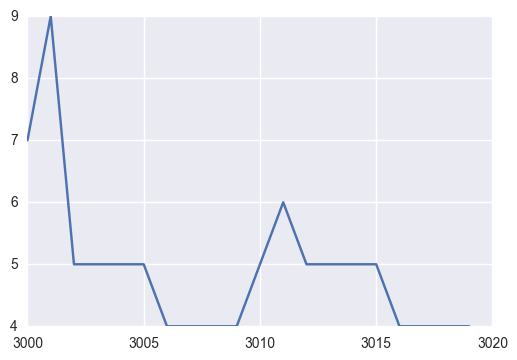

In [193]:
plt.plot(years[2:], cnt_games_233[2:])

In [194]:
train.team1.unique()

array([317,  61, 110, 352, 229, 164, 184, 245, 300,  10,  39, 205,  47,
       180,  53,  63,  82, 265,  70, 150, 188, 161, 241, 273, 232, 201,
       207, 146, 206, 234, 260, 250, 283, 302, 291, 272, 351, 159, 295,
       308,  48,  59,   4,  14,  65, 310, 287,  38,  78,  50,  96, 104,
       198, 337, 134, 320, 327, 157, 163, 168, 192, 204, 217, 220, 237,
       248, 268, 285, 249, 126, 326, 331, 129, 334,  92, 347, 322, 158,
       353, 160, 361, 135, 336,  54,  69,  16,  43,  51,  32, 254,  60,
        68,  73, 191,  87, 132,  90,  91,  11, 202,  80, 177, 179,  45,
       325, 208, 128, 274, 303, 211, 323, 299, 356, 344, 355, 269,  29,
       259,  13, 258,  35,  31,  33, 329,  64, 133, 124, 139, 173, 142,
       178,  17, 185, 210, 226, 228, 238, 209, 239, 100, 278, 293, 247,
       321,  74, 187, 122, 236, 244, 256, 275, 312, 196,  56, 172, 288,
        85,  26, 101, 111, 118, 174, 182, 339,  20, 316, 262, 328, 338,
       340, 190,  19, 218,  30, 175,  55,  81,  83, 102, 116, 12

In [195]:
df_year = train[ train['year'] == 2998]

In [196]:
scores = []
team = 174
days = []

In [203]:
home_games = np.array(df_year[df_year['team1'] == team])

In [204]:
for i in range(home_games.shape[0]):
    scores.append(home_games.[i])
    days.append(home_games.score1[i])

AttributeError: 'numpy.ndarray' object has no attribute 'score1'

In [207]:
print list(sorted(train.score1.unique()))

[81, 85, 89, 92, 96, 100, 104, 108, 112, 116, 119, 123, 127, 131, 135, 139, 143, 147, 150, 154, 158, 162, 166, 170, 174, 178, 181, 185, 189, 193, 197, 201, 205, 208, 212, 216, 220, 224, 228, 232, 236, 239, 243, 247, 251, 255, 259, 263, 267, 270, 274, 278, 282, 286, 290, 294, 297, 301, 305, 309, 313, 317, 321, 325, 328, 332, 336, 340, 344, 348, 352, 356, 359, 363, 367, 371, 375, 379, 383, 387, 390, 394, 398, 402, 406, 410, 414, 417, 421, 425, 429, 433, 437, 441, 445, 448, 452, 456, 460, 464, 468, 472, 476, 479, 483, 487, 491, 495, 499, 503, 506, 510, 514, 526, 530, 534, 541, 545, 549, 553, 565, 572, 592, 599, 603]


In [208]:
print list(sorted(train.score2.unique()))

[77, 81, 85, 92, 96, 100, 104, 108, 112, 116, 119, 123, 127, 131, 135, 139, 143, 147, 150, 154, 158, 162, 166, 170, 174, 178, 181, 185, 189, 193, 197, 201, 205, 208, 212, 216, 220, 224, 228, 232, 236, 239, 243, 247, 251, 255, 259, 263, 267, 270, 274, 278, 282, 286, 290, 294, 297, 301, 305, 309, 313, 317, 321, 325, 328, 332, 336, 340, 344, 348, 352, 356, 359, 363, 367, 371, 375, 379, 383, 387, 390, 394, 398, 402, 406, 410, 414, 417, 421, 425, 429, 433, 437, 441, 445, 448, 452, 456, 460, 464, 468, 472, 476, 479, 483, 487, 491, 495, 499, 503, 506, 510, 514, 518, 537, 541, 549, 553, 557, 580, 615]


In [209]:
years

array([2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008,
       3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019])

In [218]:
for y in years:
    df_year = train[train['year']==y]
    print len(df_year.team1.unique()), len(df_year.day.unique())

298 114
298 109
301 113
302 113
305 112
305 107
306 116
310 119
318 119
318 120
321 119
327 120
326 120
330 121
334 123
336 122
342 131
347 124
347 124
345 124
345 122
347 127


In [219]:
train.head(2)

year  day  team1  team2  score1  score2 target
0  2998   19    317    131     336     278   True
1  2998   28     61     29     301     259   True

In [240]:
X = train[['year','day']]

In [243]:
train_teams.shape

(101609, 706)

In [ ]:
X.sh

In [279]:
X = pd.concat([train_teams, pd.DataFrame(train_teams.index)], axis=1)

In [280]:
X.shape

(101609, 707)

In [281]:
X.head(2)

0    1    2    3    4    5    6    7    8    9   ...   344  345  346  347  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   348  349  350  351  352  0    
0  0.0  0.0  0.0  0.0  0.0    0  
1  0.0  0.0  0.0  0.0  0.0    1  

[2 rows x 707 columns]

In [282]:
y = train[['target']] 

In [283]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X,y, test_size=0.4)

In [284]:
train_X.shape

(60965, 707)

In [285]:
train_y.shape

(60965, 1)

In [286]:
lg = linear_model.LogisticRegression(C=0.8)

In [287]:
lg.fit(train_X, train_y)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [288]:
lg.coef_

array([[ -3.62588858e-01,  -3.83444797e-03,   1.08019517e+00,
         -7.66469905e-01,  -5.20913426e-01,  -4.66645803e-01,
         -1.15035060e+00,  -3.42722509e-01,   5.86183523e-02,
          1.65337686e+00,   5.15985211e-01,  -8.14736911e-02,
         -1.23326355e+00,   1.25627682e+00,  -1.61741269e-01,
         -1.52665040e+00,   3.13792377e-01,  -2.10868322e-01,
          3.52707736e-01,   1.44326801e-01,   5.78361598e-01,
         -1.13215291e+00,  -7.13472058e-01,   1.97194737e-01,
          4.33922134e-01,   9.68628859e-01,  -1.83274132e-02,
          8.76016050e-02,   1.80538801e-01,  -1.95839123e-01,
         -4.76911919e-01,  -4.43866553e-01,  -6.75773564e-02,
         -6.23821242e-01,   1.25820927e+00,   1.08763653e+00,
         -7.99104746e-01,  -8.99015633e-01,   7.81923124e-01,
         -7.21834855e-01,  -1.75158872e-01,  -7.85788390e-01,
         -1.12740695e+00,  -5.08836651e-01,  -9.47086940e-01,
          6.79741780e-01,  -1.93582981e-01,  -1.53847912e+00,
        

In [289]:
log_loss(test_y, lg.predict_proba(test_X)[:,1])

0.6144729902067928

In [291]:
train_X.head(2)

0    1    2    3    4    5    6    7    8    9    ...    344  345  346  \
74701  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   
61808  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0  0.0  0.0   

       347  348  349  350  351  352    0    
74701  0.0  0.0  0.0  0.0  0.0  0.0  74701  
61808  0.0  0.0  0.0  0.0  0.0  0.0  61808  

[2 rows x 707 columns]

# Последний шанс

In [348]:
train.head(5)

year  day  team1  team2  score1  score2 target
0  2998   19    317    131     336     278   True
1  2998   28     61     29     301     259   True
2  2998   28    110    141     359     267   True
3  2998   28    352    146     309     410  False
4  2998   28    229     91     332     220   True

In [349]:
target = train['score1'] - train['score2']

In [350]:
target.head(5)

0     58
1     42
2     92
3   -101
4    112
dtype: int64

In [351]:
X_train = pd.concat([train[['year']], train_teams], axis=1)

In [352]:
X_train.head(2)

year    0    1    2    3    4    5    6    7    8 ...   343  344  345  346  \
0  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1  2998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 707 columns]

In [353]:
X_train.shape

(101609, 707)

In [354]:
train_data, test_data, train_target, test_target = cross_validation.train_test_split(X_train, target, test_size=0.3)

In [355]:
train_data.head(2)

year    0    1    2    3    4    5    6    7    8 ...   343  344  345  \
37773  3007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
73832  3014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   

       346  347  348  349  350  351  352  
37773  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
73832  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 707 columns]

In [356]:
lin_cl = linear_model.LinearRegression()

In [357]:
lin_cl.fit(train_data, np.array(train_target))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [358]:
y_pred = lin_cl.predict(test_data)

In [359]:
print sklearn.metrics.mean_absolute_error(y_pred, test_target)

39.7233421051


In [360]:
 list(y_pred[:20])

[-7.8052978515625,
 -18.8409423828125,
 4.44659423828125,
 -21.564208984375,
 14.7408447265625,
 41.83349609375,
 -22.947509765625,
 0.0020751953125,
 23.463623046875,
 13.5787353515625,
 37.652587890625,
 17.95257568359375,
 -21.2742919921875,
 14.4525146484375,
 -0.57708740234375,
 12.8328857421875,
 -2.18585205078125,
 21.03216552734375,
 98.2603759765625,
 45.5989990234375]

In [368]:
an = np.array(test_target)

In [370]:
for i in range(len(y_pred)):
    if y_pred[i]>0:
        y_pred[i]=1
    else:
        y_pred[i]=0
    if an[i]>0:
        an[i]=1
    else:
        an[i]=0

In [373]:
sklearn.metrics.log_loss(an, y_pred)

11.874503433016764

### Нейронная сеть

In [479]:
from pybrain.datasets import ClassificationDataSet # Структура данных pybrain
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError

In [480]:
# Определение основных констант
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

In [481]:
X_train.head(2)

year  mean_home_score  mean_away_score  percentage_wins_home  \
0 -1.752835         1.411135         1.134001              1.573942   
1 -1.752835         0.236316         0.468392              0.019886   

   percentage_wins_away    0    1    2    3    4 ...   343  344  345  346  \
0              1.261859  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1              0.518128  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 711 columns]

In [482]:
X_train.shape

(101609, 711)

In [483]:
X_test.head(2)

year  mean_home_score  mean_away_score  percentage_wins_home  \
0  1.873146        -1.452486         0.616305             -0.609021   
1  1.873146         0.089464        -2.046131              0.778944   

   percentage_wins_away    0    1    2    3    4 ...   343  344  345  346  \
0              0.329087  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1             -0.935227  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   347  348  349  350  351  352  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 711 columns]

In [484]:
y_train.shape

(101609, 1)

In [485]:
X_test.shape

(125207, 711)

In [486]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X_train, y_train)
train_labels = train_labels.values
test_labels = test_labels.values

In [487]:
ds_train = ClassificationDataSet(np.shape(X_train)[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', train_data)
ds_train.setField('target', train_labels[:, np.newaxis])
ds_test = ClassificationDataSet(np.shape(X_test)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', test_data)
ds_test.setField('target', test_labels[:, np.newaxis])

In [488]:
np.random.seed(0)  # Зафиксируем seed для получения воспроизводимого результата

In [489]:
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer)

In [490]:
init_params = np.random.random((len(net.params))) 

In [491]:
net._setParameters(init_params)

In [493]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np

In [ ]:
random.seed(0)
# Модуль настройки параметров pybrain использует модуль random; зафиксируем seed для получения воспроизводимого результата
trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')